<a href="https://colab.research.google.com/github/gabrieletirrito/Paintings-Classifier-/blob/main/art_style_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.models import Model
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from keras.optimizers import Adam

# Art style Classification

The dataset employed for this work is **ARTEMIS**. First, it is imported.

In [ ]:
artemis = pd.read_csv('/kaggle/input/artemis/artemis_dataset_release_v0.csv')
artemis

,art_style,painting,emotion,utterance,repetition
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10
...,...,...,...,...,...
454679,Cubism,gino-severini_a-dancer-1,awe,the collection and collage of different colors...,48
454680,Romanticism,ivan-aivazovsky_sea-at-night-1861,awe,The peaceful reflections of the moonlight on t...,8
454681,Romanticism,ivan-aivazovsky_sea-at-night-1861,excitement,I can imagine the sailors resting this peacefu...,8
454682,Romanticism,ivan-aivazovsky_sea-at-night-1861,contentment,The steep mountains and the moonlight provide ...,8


The given function, **generate_path**, constructs the file path for images in the Artemis dataset sourced from WikiArt. It utilizes information from two columns in the dataset: art_style and painting.

The function takes a row from the dataset as input and generates a file path based on the values in the art_style and painting columns. It then formats the path string to include these values, creating a path that points to the respective image file in the WikiArt dataset.

When applied to the dataset using the apply function, this function generates a new column containing the file paths for each painting in the dataset. These paths can then be used to access the corresponding image files for further analysis or visualization.

In [ ]:
def generate_path(row):
    return f"/kaggle/input/wikiart/{row['art_style']}/{row['painting']}.jpg"

artemis['path'] = artemis.apply(generate_path, axis=1)
artemis['path']

0         /kaggle/input/wikiart/Post_Impressionism/vince...
1         /kaggle/input/wikiart/Post_Impressionism/vince...
2         /kaggle/input/wikiart/Post_Impressionism/vince...
3         /kaggle/input/wikiart/Post_Impressionism/vince...
4         /kaggle/input/wikiart/Post_Impressionism/vince...
                                ...                        
454679    /kaggle/input/wikiart/Cubism/gino-severini_a-d...
454680    /kaggle/input/wikiart/Romanticism/ivan-aivazov...
454681    /kaggle/input/wikiart/Romanticism/ivan-aivazov...
454682    /kaggle/input/wikiart/Romanticism/ivan-aivazov...
454683    /kaggle/input/wikiart/Cubism/joan-miro_not_det...
Name: path, Length: 454684, dtype: object

The code below ensures that the artemis DataFrame contains only unique rows with existing paths, removing any duplicates and non-existing paths.

In [ ]:
def path_exists(path):
    return os.path.exists(path)

# artemis = artemis[artemis['path'].apply(path_exists)]
artemis = artemis.drop_duplicates(subset=['path'])

In [ ]:
# artemis.to_csv('artemis-full.csv', index=False)
artemis = pd.read_csv('/kaggle/input/artemis-full/artemis.csv')

In [ ]:
u_art = artemis.art_style.unique()
print(f"\n{'='*10} Unique Art_styles {'='*10}\n{u_art}\n{'='*10} Total: {len(u_art)} {'='*10}")


========== Unique Art_styles ==========
['Post_Impressionism' 'Expressionism' 'Impressionism'
 'Northern_Renaissance' 'Realism' 'Romanticism' 'Symbolism'
 'Art_Nouveau_Modern' 'Naive_Art_Primitivism' 'Baroque' 'Rococo'
 'Abstract_Expressionism' 'Cubism' 'Color_Field_Painting' 'Pop_Art'
 'Pointillism' 'Early_Renaissance' 'Ukiyo_e' 'Mannerism_Late_Renaissance'
 'High_Renaissance' 'Fauvism' 'Minimalism' 'Action_painting'
 'Contemporary_Realism' 'Synthetic_Cubism' 'New_Realism'
 'Analytical_Cubism']
========== Total: 27 ==========


The provided code calculates the percentage distribution of different art styles in the dataset. It first calculates the count of each unique art style, then computes the total count of all art styles. Finally, it calculates the percentage for each.

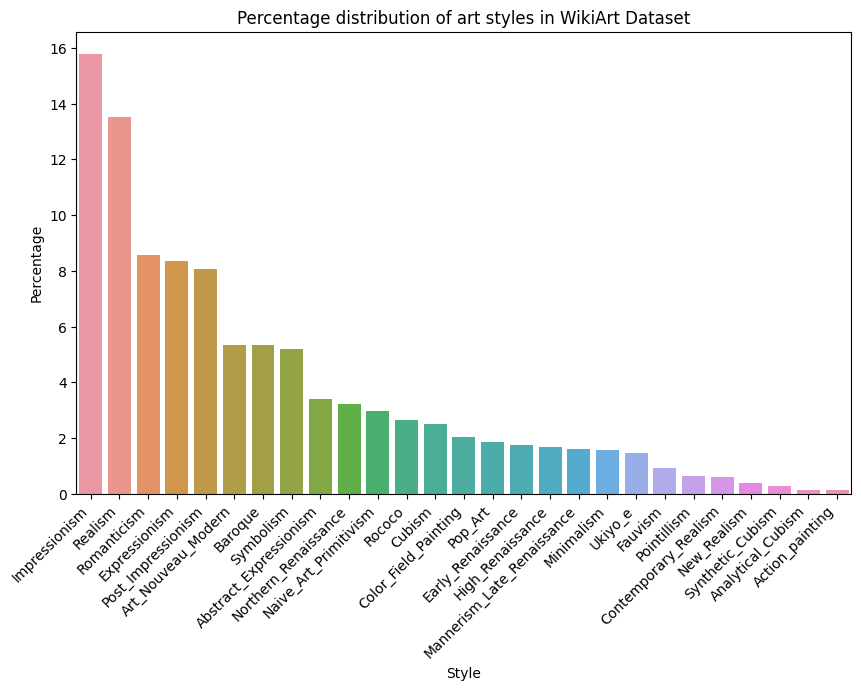

In [ ]:
art_style_counts = artemis['art_style'].value_counts()

total_count = art_style_counts.sum()
art_style_percentages = (art_style_counts / total_count) * 100

art_style_percentages_df = pd.DataFrame({'art_style': art_style_percentages.index, 'percentage': art_style_percentages.values})

plt.figure(figsize=(10, 6))
sns.barplot(x='art_style', y='percentage', data=art_style_percentages_df)
plt.title('Percentage distribution of art styles in WikiArt Dataset')
plt.xlabel('Style')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.show()

To retain 75% of the entire dataset while ensuring significant classes for classification are preserved, any art styles with less than 4% representation in the dataset were ignored and discarded. This ensures that only art styles with a substantial representation, i.e., at least 4% of the dataset, are included in the retained portion.

In [ ]:
threshold = 4
classes = art_style_percentages_df[art_style_percentages_df['percentage'] >= threshold]
art_styles_list = classes['art_style'].tolist()

In [ ]:
art_styles_list

['Impressionism',
 'Realism',
 'Romanticism',
 'Expressionism',
 'Post_Impressionism',
 'Art_Nouveau_Modern',
 'Baroque',
 'Symbolism']

In [ ]:
paintings = artemis[artemis['art_style'].isin(art_styles_list)]

In [ ]:
paintings

,art_style,painting,emotion,utterance,repetition,path
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
5,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,/kaggle/input/wikiart/Expressionism/wassily-ka...
7,Impressionism,konstantin-korovin_yaroslavna-s-lament-1909,awe,the stroke of blue paint used to outline the h...,7,/kaggle/input/wikiart/Impressionism/konstantin...
9,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,awe,The golden gloves and white dress stand out an...,7,/kaggle/input/wikiart/Impressionism/paul-gaugu...
11,Impressionism,pericles-pantazis_still-life-with-quinces-1880,contentment,The pears are just about ripe to eat and enjoy,7,/kaggle/input/wikiart/Impressionism/pericles-p...
...,...,...,...,...,...,...
387461,Realism,james-tissot_the-artist-s-ladies-1885,excitement,The white table clothes bring out the colors o...,6,/kaggle/input/wikiart/Realism/james-tissot_the...
387743,Post_Impressionism,suzanne-valadon_nudes-1919,amusement,These two girls remind me of Ariel and Snow Wh...,6,/kaggle/input/wikiart/Post_Impressionism/suzan...
388043,Romanticism,lev-lagorio_along-the-coast-livadia-1895,something else,looks like a large hand emerging from the water,6,/kaggle/input/wikiart/Romanticism/lev-lagorio_...
388706,Impressionism,eduardo-viana_untitled,something else,I cannot exactly tell what is going on in the ...,6,/kaggle/input/wikiart/Impressionism/eduardo-vi...


In [ ]:
def load_image(image_path):
    '''
    Args:
        image_path: A string representing the path to the image file.

    Returns:
        img: The image retrieved from the given path is read as a JPEG image with three color channels (RGB), resized to dimensions of 299x299 pixels, preprocessed using the InceptionV3 preprocessing function,
             and then returned as a NumPy array.
        img_path: The original image path.
    '''
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = img.numpy()
    return img, image_path

In [ ]:
one_example_per_class = paintings.groupby('art_style').first()
paths_per_class = one_example_per_class['path']

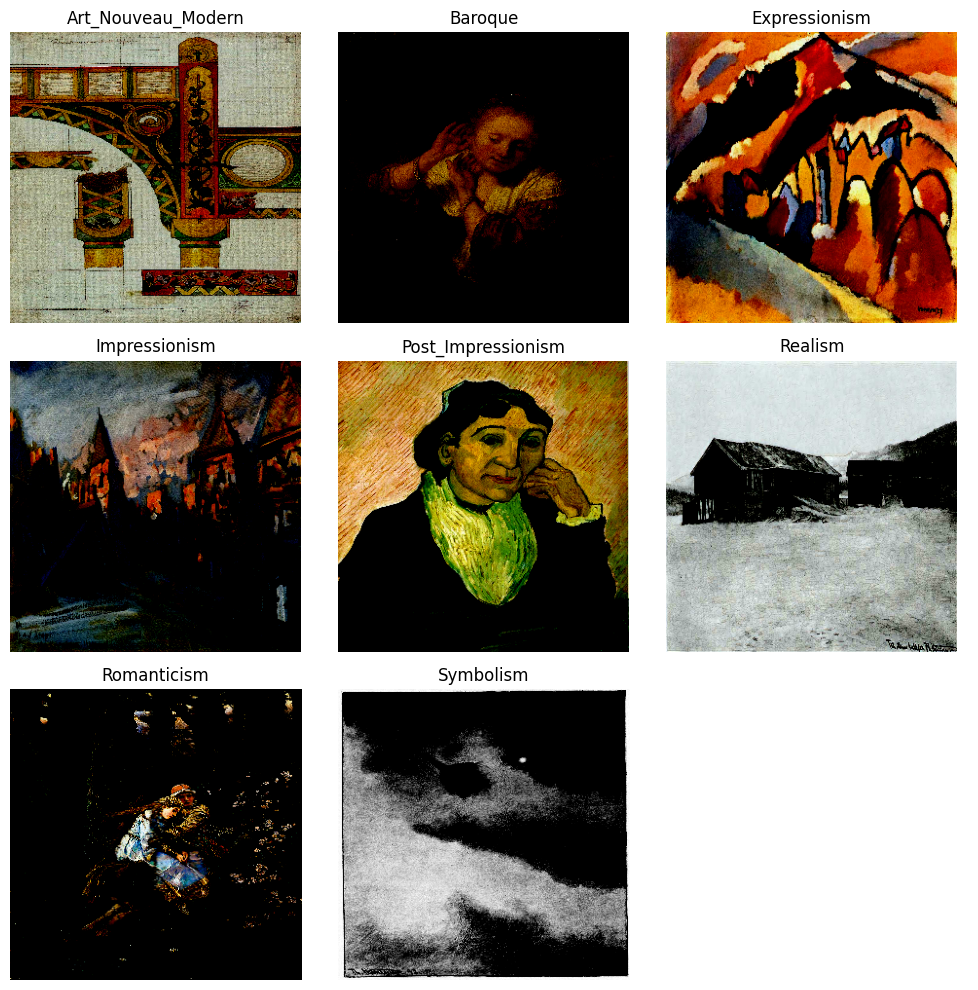

In [ ]:
def visualize(paths_per_class):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, (art_style, img_path) in enumerate(paths_per_class.items()):
        img = load_image(img_path)[0]

        row = i // 3
        col = i % 3

        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(art_style)

    for j in range(len(paths_per_class), 9):
        row = j // 3
        col = j % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

visualize(paths_per_class)

The code is performing undersampling using the _RandomUnderSampler_ from the imbalanced-learn library. Specifically:

1. It applies the fit_resample method of the RandomUnderSampler object to balance the dataset by randomly removing samples from the majority class(es) to match the number of samples in the minority class(es).
2. It assigns the resampled paths and corresponding art styles to variables x and y, respectively.

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='auto')
x, y = undersampler.fit_resample(paintings['path'].values.reshape(-1,1), paintings['art_style'].values.reshape(-1,1))
art_styles = pd.DataFrame({'path':x.flatten(), 'style':y.flatten()})

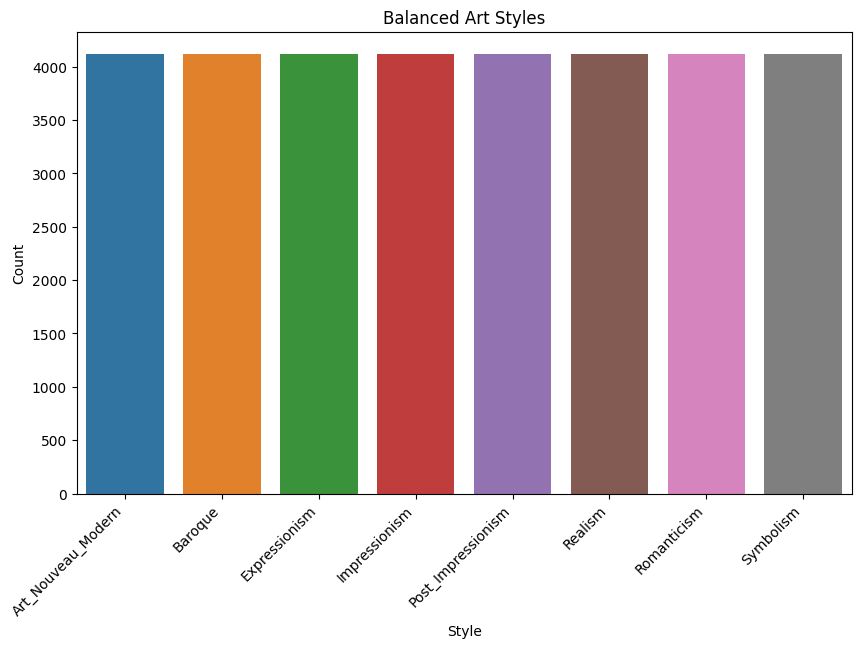

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='style', data=art_styles)
plt.title('Balanced Art Styles')
plt.xlabel('Style')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

This code snippet utilizes the _OneHotEncoder_ from the scikit-learn library to transform the categorical 'art_style' column into a one-hot encoded representation. Each path in the dataset is associated with a sparse matrix where each row corresponds to a path, and each column represents a distinct art style. Within this matrix, a value of 1 indicates the presence of the corresponding art style for a particular path.

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_array = enc.fit_transform(art_styles[['style']])
encoded_df = pd.DataFrame(encoded_array, index=art_styles['path'])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
encoded_df

,0,1,2,3,4,5,6,7
path,,,,,,,,
/kaggle/input/wikiart/Art_Nouveau_Modern/mikhail-vrubel_archangel-gabriel-1885.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/kaggle/input/wikiart/Art_Nouveau_Modern/heorhiy-narbut_sheet-i-from-the-album-ukrainian-alphabet-1917.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/kaggle/input/wikiart/Art_Nouveau_Modern/jacek-malczewski_portrait-of-w-adys-aw-ele-ski-1908.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/kaggle/input/wikiart/Art_Nouveau_Modern/ferdinand-hodler_unity-1911.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/kaggle/input/wikiart/Art_Nouveau_Modern/edmund-dulac_human-or-divine-the-rubaiyat-of-omar-khayyam.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
/kaggle/input/wikiart/Symbolism/roger-de-la-fresnaye_a-romanian.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
/kaggle/input/wikiart/Symbolism/william-blake_illustration-to-milton-s-paradise-lost-1808-4.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
/kaggle/input/wikiart/Symbolism/william-blake_christ-refusing-the-banquet-offered-by-satan-1820.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df.index.values, np.ndarray.astype(encoded_df.values, np.int64), test_size=0.2, random_state=42)

The code sets up TensorFlow datasets for training and validation using numpy files. Specifically:

1. It defines a map function **map_func** that loads image tensors and their corresponding labels from numpy files.
2. It creates TensorFlow datasets using _tf.data.Dataset.from_tensor_slices()_ for both training and validation, passing in the numpy arrays X_train, y_train, X_test, and y_test.
3. It uses map() to apply the map_func to each element of the datasets, ensuring that image tensors are loaded in parallel.
4. It ensures that the shape of each image tensor is (299, 299, 3) and the shape of each label tensor is (8) using _tf.ensure_shape()_.
5. It shuffles and batches the datasets using _shuffle()_ and _batch()_, respectively.
6. It prefetches elements from the datasets to improve performance using _prefetch()_ with the buffer_size set to tf.data.experimental.AUTOTUNE.

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, style):
    img_tensor = load_image(img_name.decode('utf-8'))[0]
    return img_tensor, style

dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((np.array(X_test), y_test))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(lambda item1, item2: (tf.ensure_shape(item1, (299, 299, 3)), tf.ensure_shape(item2, (8,))))

dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.map(lambda item1, item2: (tf.ensure_shape(item1, (299, 299, 3)), tf.ensure_shape(item2, (8,))))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

The code retrieves the first batch of data from the validation dataset and prints it.

In [ ]:
first_pair = next(iter(dataset_val.take(1)))
print(first_pair)

(<tf.Tensor: shape=(64, 299, 299, 3), dtype=float32, numpy=
array([[[[-0.25786614, -0.34414065, -0.4853171 ],
         [-0.25934815, -0.34562266, -0.48679912],
         [-0.27546972, -0.36174423, -0.50292075],
         ...,
         [-0.36157125, -0.3301987 , -0.3066693 ],
         [-0.3275295 , -0.29615694, -0.27262753],
         [-0.3333333 , -0.30196077, -0.27843136]],

        [[-0.25778735, -0.34406185, -0.48523837],
         [-0.26651525, -0.35278976, -0.49396628],
         [-0.28670734, -0.37298185, -0.5141583 ],
         ...,
         [-0.3776173 , -0.3462447 , -0.32271528],
         [-0.37971616, -0.3483436 , -0.3248142 ],
         [-0.35968935, -0.3283168 , -0.3047874 ]],

        [[-0.33025044, -0.42927337, -0.5641125 ],
         [-0.26174653, -0.3569396 , -0.49369055],
         [-0.3089128 , -0.39607912, -0.5368366 ],
         ...,
         [-0.33334643, -0.30197388, -0.27844447],
         [-0.34563977, -0.31426722, -0.2907378 ],
         [-0.35044676, -0.3190742 , -0.29557

In [ ]:
base_model = applications.InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(299,299,3))
base_model.trainable = True

add_model = Sequential()
add_model.add(GlobalAveragePooling2D())
add_model.add(Dense(1024, activation='ReLU'))
add_model.add(Dropout(0.1))
add_model.add(Dense(512, activation='ReLU'))
add_model.add(Dropout(0.1))
add_model.add(Dense(256, activation='ReLU'))
add_model.add(Dense(8, activation='softmax'))

model = tf.keras.Sequential([
    tf.keras.Input(shape=(299,299,3)),
    keras.layers.RandomRotation(0.5),
    keras.layers.RandomCrop(299, 299),
    keras.layers.RandomTranslation(0.5,0.5),
    base_model,
    add_model
])

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer= 'adamax',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomR  (None, 299, 299, 3)       0         
 otation)                                                        
                                                                 
 random_crop_2 (RandomCrop)  (None, 299, 299, 3)       0         
                                                                 
 random_translation_2 (Rand  (None, 299, 299, 3)       0         
 omTranslation)                                                  
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 8)                 2756360   
                                                                 
Total params: 24559144 (93.69 MB)
Trainable params: 24

In [ ]:
history = model.fit(dataset, epochs=20, validation_data = dataset_val)

Epoch 1/20
207/207 [==============================] - 593s 3s/step - loss: 0.3032 - accuracy: 0.4099 - val_loss: 0.3207 - val_accuracy: 0.3960
Epoch 2/20
207/207 [==============================] - 502s 2s/step - loss: 0.2649 - accuracy: 0.5033 - val_loss: 0.2929 - val_accuracy: 0.4824
Epoch 3/20
207/207 [==============================] - 459s 2s/step - loss: 0.2497 - accuracy: 0.5383 - val_loss: 0.2940 - val_accuracy: 0.4430
Epoch 4/20
207/207 [==============================] - 452s 2s/step - loss: 0.2385 - accuracy: 0.5618 - val_loss: 0.2958 - val_accuracy: 0.4713
Epoch 5/20
207/207 [==============================] - 448s 2s/step - loss: 0.2293 - accuracy: 0.5803 - val_loss: 0.2774 - val_accuracy: 0.4791
Epoch 6/20
207/207 [==============================] - 450s 2s/step - loss: 0.2208 - accuracy: 0.5951 - val_loss: 0.2653 - val_accuracy: 0.5038
Epoch 7/20
207/207 [==============================] - 471s 2s/step - loss: 0.2134 - accuracy: 0.6130 - val_loss: 0.2534 - val_accuracy: 0.5344

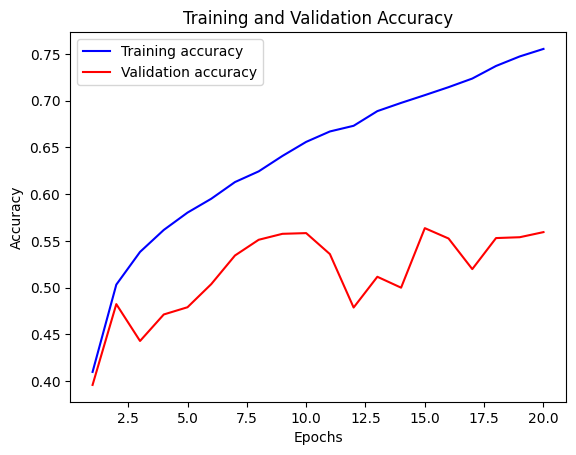

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model.save('model.keras')

In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in dataset_val:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
true_labels = np.argmax(correct_labels.numpy(), axis = 1)

3/3 [==============================] - 0s 71ms/step


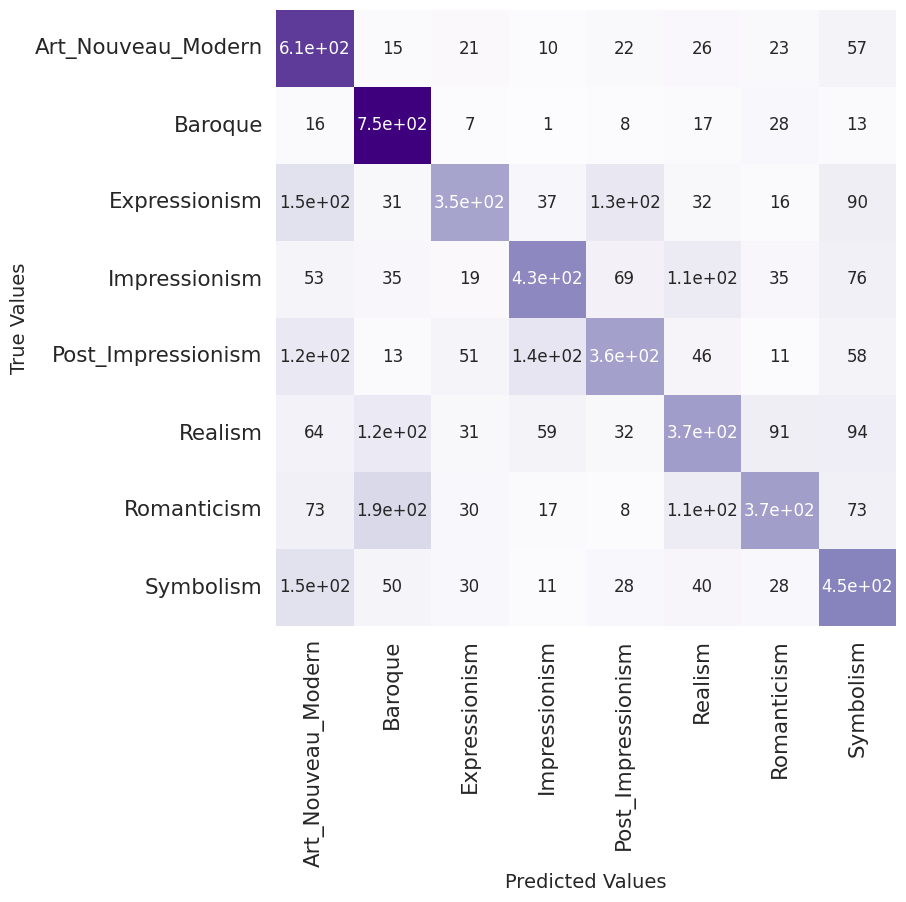

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels.numpy())

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', xticklabels=enc.categories_[0].tolist(), yticklabels=enc.categories_[0].tolist());
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

In [ ]:
Y_pred = model.predict(dataset_val)
y_pred = np.argmax(Y_pred, axis=1)

l = len(X_test)
sampled_indices = random.sample(range(l), 9)
image_paths = [X_test[i] for i in sampled_indices]
image_labels = [enc.inverse_transform(y_test[i].reshape(1, -1))[0][0] for i in sampled_indices]

image_data = [load_image(path)[0] for path, label in zip(image_paths, image_labels)]
image_data = tf.convert_to_tensor(image_data)

Y_pred_test = model.predict(image_data)
y_pred_test = np.argmax(Y_pred_test, axis=1)

1/1 [==============================] - 0s 37ms/step


In [ ]:
predicted_values = [enc.categories_[0][i] for i in y_pred_test.tolist()]

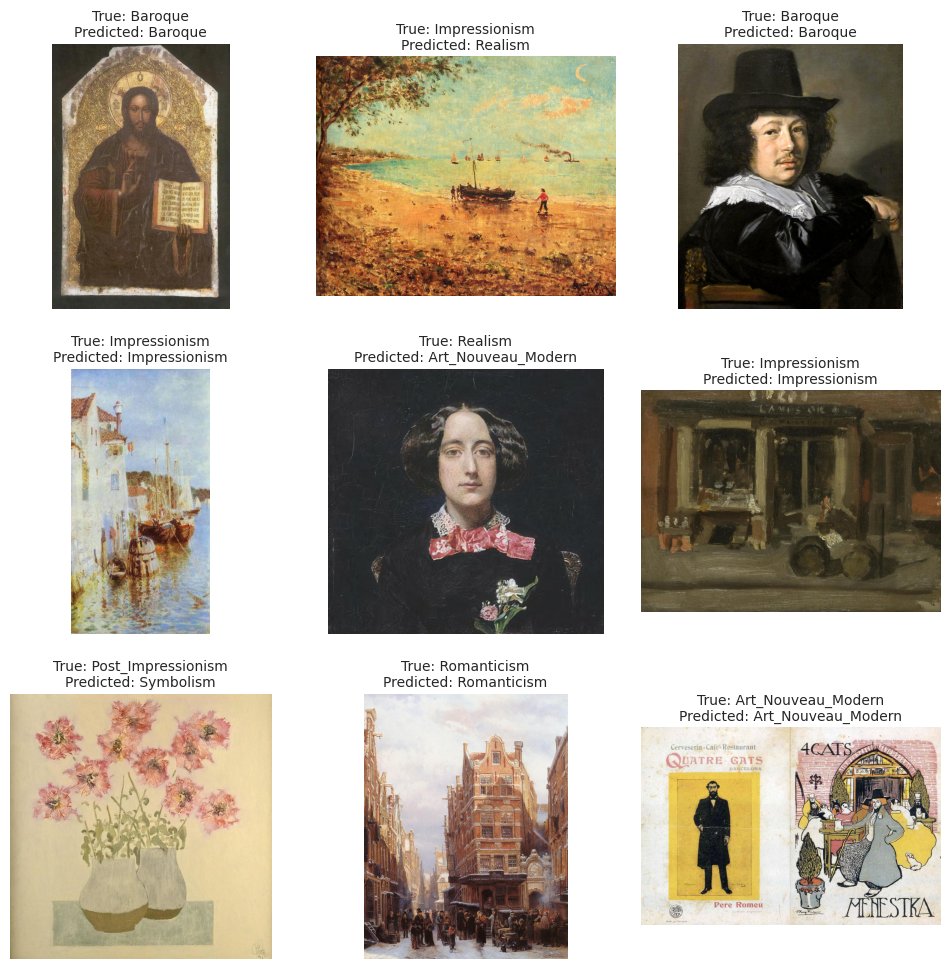

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, (path, label, pred) in enumerate(zip(image_paths, image_labels, predicted_values)):
    row = i // 3
    col = i % 3
    img = mpimg.imread(path)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].set_title(f"True: {label}\nPredicted: {pred}", fontsize=10, pad=5)

plt.tight_layout()
plt.show()